In [2]:
#!pip install kaggle

In [15]:
#!kaggle competitions download -c dogs-vs-cats

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
from zipfile import ZipFile
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.math import confusion_matrix
import seaborn as sns


In [22]:
path = 
def un_zep(path)
    with ZipFile(path, 'r') as zip:
      zip.extractall()
      print('The dataset has been extracted successfully')

In [23]:
un_zip('dogs-vs-cats.zip')

The dataset has been extracted successfully


In [24]:
un_zip('train.zip')

The dataset has been extracted successfully


In [3]:
def show_image(path):
    img = mpimg.imread(path)
    imgplt = plt.imshow(img)
    plt.show()

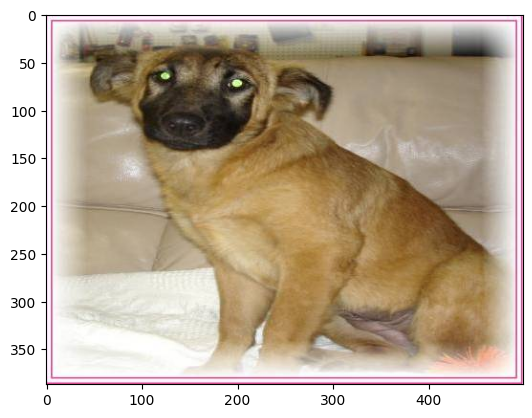

In [4]:
show_image('train/dog.820.jpg')

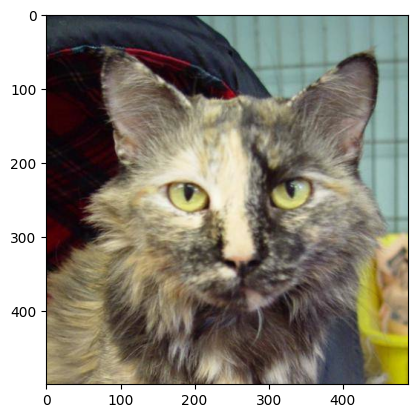

In [5]:
show_image('train/cat.10.jpg')

#### Data distribution

In [6]:
filenames = os.listdir('train')
print('Total images :', len(filenames))

cat_count = sum('cat.' in filename for filename in filenames)
dog_count = sum('dog.' in filename for filename in filenames)

print('Total cats :', cat_count)
print('Total dogs :', dog_count)



Total images : 25000
Total cats : 12500
Total dogs : 12500


#### Preprocess 5000 pictures of each type

In [7]:
def process_image(img):
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        # Convert RGBA to RGB
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    #resize to keep all image size same
    return cv2.resize(img, (224,224))/255

def get_label_name(l):
    if l == 1:
        return 'dog'
    else:
        return 'cat'
    
    

In [8]:
dataset_path = 'train/'
num_files = len(filenames)
image_shape = (224, 224, 3) 

data = np.zeros((5000*2,) + image_shape, dtype=np.float32)
labels = np.zeros((5000*2,), dtype=np.int8)

j = 0
for i in range(5000) :
    file = f'cat.{i}.jpg'
    img = mpimg.imread(dataset_path + file)
    data[j] = process_image(img)  
    labels[j] = 0
    # dog
    file = f'dog.{i}.jpg'
    img = mpimg.imread(dataset_path + file)
    data[j+1] = process_image(img)  
    labels[j+1] = 1
    j += 2




#### Visulize the processed data

In [9]:
print('total image:', len(data))
print('total label:', len(labels))
data[0].shape

total image: 10000
total label: 10000


(224, 224, 3)

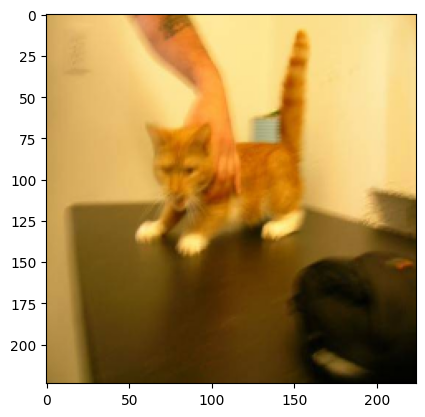

Type : cat


In [10]:
plt.imshow(data[0])
plt.show()
print('Type :', get_label_name(labels[0]))

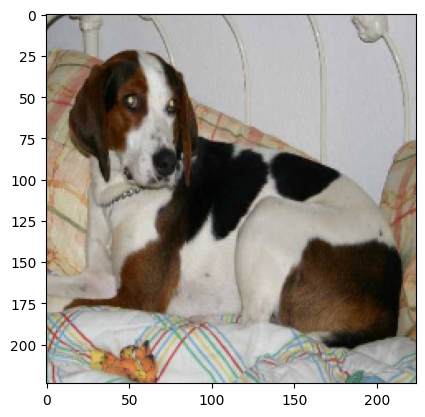

Type : dog


In [11]:
plt.imshow(data[-1])
plt.show()
print('Type :', get_label_name(labels[-1]))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)

del data
del labels


### Transfer Learning

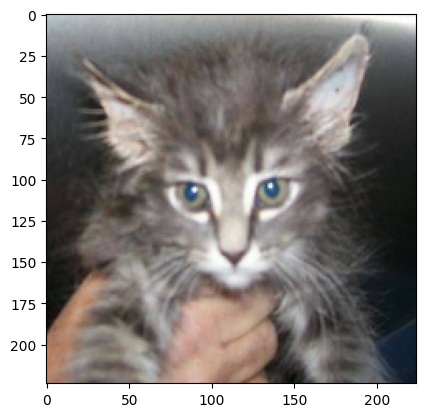

Type : cat


In [13]:
plt.imshow(X_train[0])
plt.show()
print('Type :', get_label_name(y_train[0]))

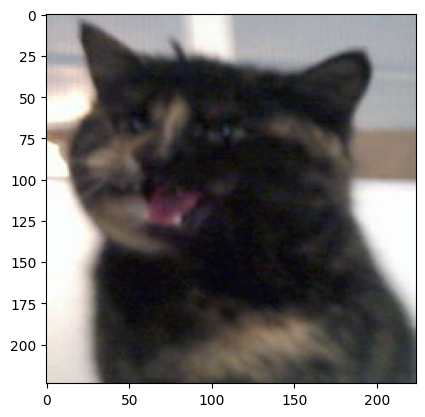

Type : cat


In [14]:
plt.imshow(X_train[-1])
plt.show()
print('Type :', get_label_name(y_train[-1]))

In [30]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.build(input_shape=(None, 224, 224, 3))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │       2,007,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,265,122 (16.27 MB)

 Trainable params: 2,007,138 (7.66 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
model.compile(optimizer='adam', 
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [32]:
info = model.fit(X_train, y_train, validation_split=0.1, epochs=5)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 133s 570ms/step - accuracy: 0.9354 - loss: 0.2681 - val_accuracy: 0.9837 - val_loss: 0.0390
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 139s 555ms/step - accuracy: 0.9896 - loss: 0.0310 - val_accuracy: 0.9787 - val_loss: 0.0545
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 133s 593ms/step - accuracy: 0.9942 - loss: 0.0161 - val_accuracy: 0.9725 - val_loss: 0.0788
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 129s 571ms/step - accuracy: 0.9979 - loss: 0.0066 - val_accuracy: 0.9825 - val_loss: 0.0547
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 143s 575ms/step - accuracy: 0.9985 - loss: 0.0031 - val_accuracy: 0.9850 - val_loss: 0.0883


## CNN

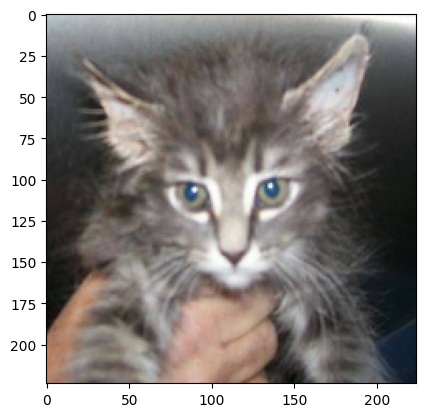

Type : cat


In [19]:
plt.imshow(X_train[0])
plt.show()
print('Type :', get_label_name(y_train[0]))

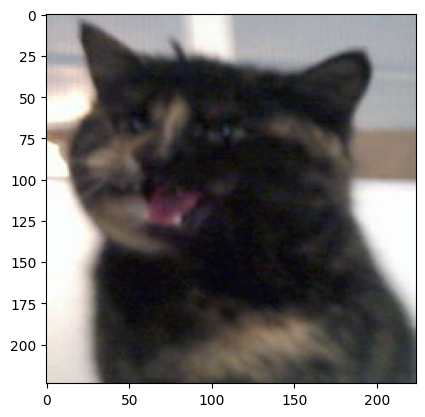

Type : cat


In [20]:
plt.imshow(X_train[-1])
plt.show()
print('Type :', get_label_name(y_train[-1]))

In [23]:


cnn = tf.keras.Sequential()

# Convolutional Base
cnn.add(layers.Conv2D(10, kernel_size=3, activation='relu', input_shape=X_train[0].shape ))
cnn.add(layers.MaxPooling2D(2, 2))
cnn.add(layers.Conv2D(15, kernel_size=3, activation='relu'))
cnn.add(layers.MaxPooling2D(2, 2))
cnn.add(layers.Conv2D(20, kernel_size=3, activation='relu'))
cnn.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
cnn.add(layers.MaxPooling2D(2, 2))
cnn.add(layers.Conv2D(10, kernel_size=3, activation='relu'))
cnn.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
cnn.add(layers.Conv2D(64, kernel_size=3, activation='relu'))

# Classifier
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(2, activation='softmax'))  # Use 'softmax' for one-hot encoded labels

cnn.summary()
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 111, 111, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 109, 109, 15)        │           1,365 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 54, 54, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 52, 52, 20)          │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 50, 50, 32)          │           5,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 23, 23, 10)          │           2,890 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 21, 21, 32)          │           2,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 19, 19, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 23104)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │         739,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 773,881 (2.95 MB)

 Trainable params: 773,881 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
cnn.compile(optimizer='adam', 
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [25]:
cnn_info = cnn.fit(X_train, y_train, validation_split=0.1, epochs=10)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 51s 209ms/step - accuracy: 0.5394 - loss: 0.6900 - val_accuracy: 0.6300 - val_loss: 0.6483
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 206ms/step - accuracy: 0.6026 - loss: 0.6566 - val_accuracy: 0.5738 - val_loss: 0.6506
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 314ms/step - accuracy: 0.6164 - loss: 0.6432 - val_accuracy: 0.6438 - val_loss: 0.6348
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 64s 284ms/step - accuracy: 0.6499 - loss: 0.6203 - val_accuracy: 0.6750 - val_loss: 0.6247
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - accuracy: 0.6873 - loss: 0.5902 - val_accuracy: 0.7287 - val_loss: 0.5780
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - accuracy: 0.7151 - loss: 0.5596 - val_accuracy: 0.7075 - val_loss: 0.5540
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - accuracy: 0.7443 - loss: 0.5236 - val_accuracy: 0.7400 - val_loss: 0.5227
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - accuracy: 0.7869 - loss: 0

### Evaluation--- Transfer Learning(TL) vs CNN

In [33]:
loss, acc = model.evaluate(X_test, y_test)
print('TL test Acuuracy : ', acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - accuracy: 0.9821 - loss: 0.0989
TL test Acuuracy :  0.9800000190734863


In [34]:
loss, acc = cnn.evaluate(X_test, y_test)
print('Cnn test Acuuracy : ', acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.7741 - loss: 0.5099
Cnn test Acuuracy :  0.7699999809265137


##### TL

In [35]:
y_predict = model.predict(X_test)
y_predict = [np.argmax(i) for i in y_predict]
c_m = confusion_matrix(y_test, y_predict)

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 480ms/step


Text(0.5, 47.7222222222222, 'Predicted Labels')

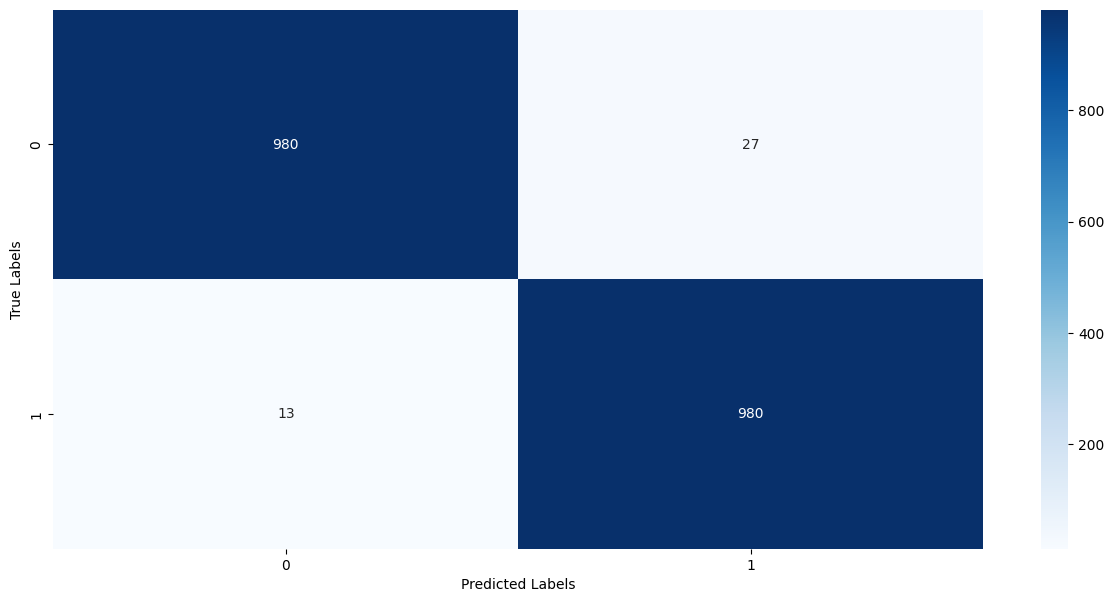

In [71]:
plt.figure(figsize=(15,7))
sns.heatmap(c_m, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

#### CNN

In [68]:
y_predict = cnn.predict(X_test)
y_predict = [np.argmax(i) for i in y_predict]
c_m = confusion_matrix(y_test, y_predict)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


Text(0.5, 47.7222222222222, 'Predicted Labels')

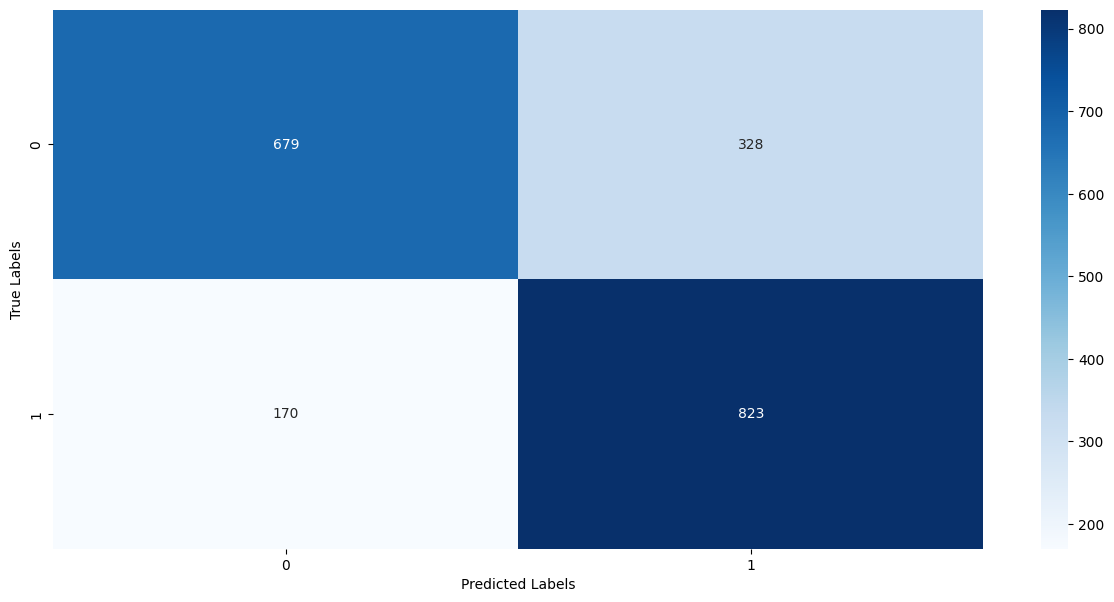

In [69]:
plt.figure(figsize=(15,7))
sns.heatmap(c_m, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

##### TL

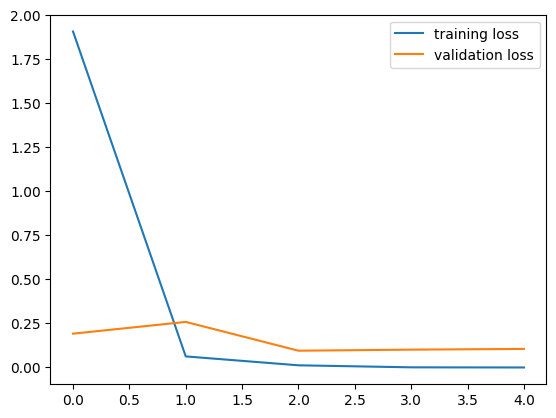

In [53]:
plt.plot(info.history['loss'], label='training loss')
plt.plot(info.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

##### CNN

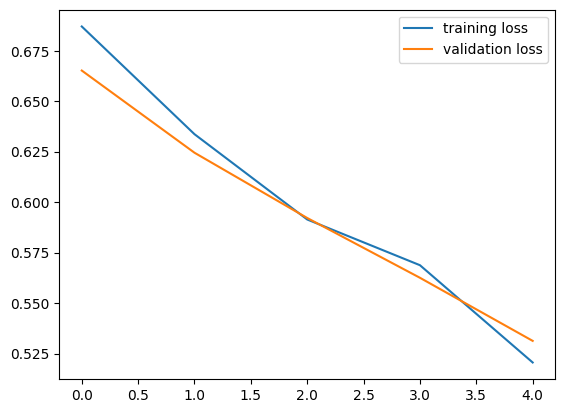

In [72]:
plt.plot(cnn_info.history['loss'], label='training loss')
plt.plot(cnn_info.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

##### TL

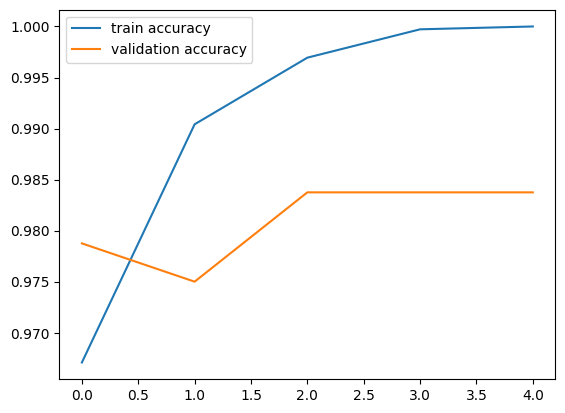

In [55]:
plt.plot(info.history['accuracy'], label='train accuracy')
plt.plot(info.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

#### CNN

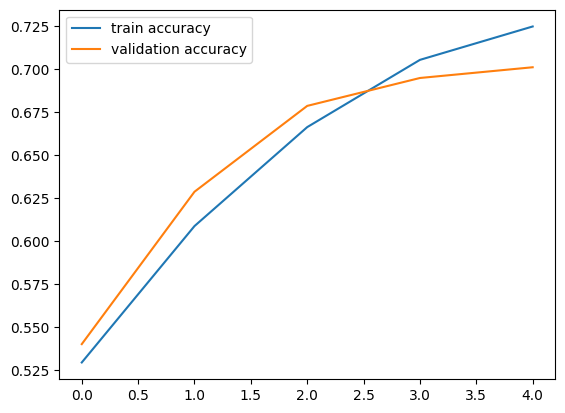

In [56]:
plt.plot(cnn_info.history['accuracy'], label='train accuracy')
plt.plot(cnn_info.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()